In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import *
from imblearn.metrics import specificity_score

In [ ]:
# from imblearn.combine import SMOTETomek
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import OneSidedSelection
# from imblearn.under_sampling import TomekLinks

In [3]:
import time
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [4]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

### Getting Data

In [5]:
res = pd.read_csv('../Outputs/resampled_cat.csv', encoding='cp949', index_col=0)
test = pd.read_csv('../Outputs/test_set_cat.csv', encoding='cp949', index_col=0)
res = res.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [6]:
X_res, y_res = res.iloc[:, :-1], res.iloc[:, -1] 
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

### Model Fitting

In [22]:
def objective(trial: Trial, X_train, y_train):
    params = {
        'n_estimators':trial.suggest_int('n_estimators', 50, 600),
        'learning_rate':trial.suggest_float('learning_rate', 0.0005, 0.3),
        'depth':trial.suggest_int('depth', 3, 12),
        'cat_features':['인접도로구분', '브랜드']
    }
    
    cat_model = CatBoostClassifier(**params, cat_features=['인접도로구분', '브랜드'],
                                   verbose=1, eval_metric='AUC', random_state=42)
    cat_model.fit(X_train, y_train)
    if trial.should_prune():
        raise optuna.TrialPruned()

    y_pred = cat_model.predict(X_test)
    score = roc_auc_score(y_test, y_pred)                                               
    # score = cross_val_score(lg_model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    
    return score

In [ ]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial:objective(trial, X_res, y_res), n_trials=20)

In [7]:
cat_model = CatBoostClassifier(n_estimators=428, learning_rate=0.19423877190623967,
                               depth=5, random_state=42, cat_features=['인접도로구분', '브랜드'])
cat_model.fit(X_res, y_res)

0:	learn: 0.5291000	total: 566ms	remaining: 4m 1s
1:	learn: 0.4259003	total: 749ms	remaining: 2m 39s
2:	learn: 0.3668750	total: 957ms	remaining: 2m 15s
3:	learn: 0.3312762	total: 1.12s	remaining: 1m 58s
4:	learn: 0.3098546	total: 1.37s	remaining: 1m 56s
5:	learn: 0.2923036	total: 1.6s	remaining: 1m 52s
6:	learn: 0.2811890	total: 1.83s	remaining: 1m 50s
7:	learn: 0.2737194	total: 2.08s	remaining: 1m 49s
8:	learn: 0.2654159	total: 2.32s	remaining: 1m 47s
9:	learn: 0.2610146	total: 2.53s	remaining: 1m 45s
10:	learn: 0.2557018	total: 2.74s	remaining: 1m 43s
11:	learn: 0.2515258	total: 2.94s	remaining: 1m 41s
12:	learn: 0.2476652	total: 3.16s	remaining: 1m 40s
13:	learn: 0.2444008	total: 3.35s	remaining: 1m 38s
14:	learn: 0.2410747	total: 3.53s	remaining: 1m 37s
15:	learn: 0.2389891	total: 3.71s	remaining: 1m 35s
16:	learn: 0.2364854	total: 3.91s	remaining: 1m 34s
17:	learn: 0.2346657	total: 4.07s	remaining: 1m 32s
18:	learn: 0.2328412	total: 4.25s	remaining: 1m 31s
19:	learn: 0.2312122	tot

### Making Predictions

In [8]:
y_pred = cat_model.predict(X_test)
y_pred_prob = cat_model.predict_proba(X_test)[:, 1]

### Plotting and Metrics

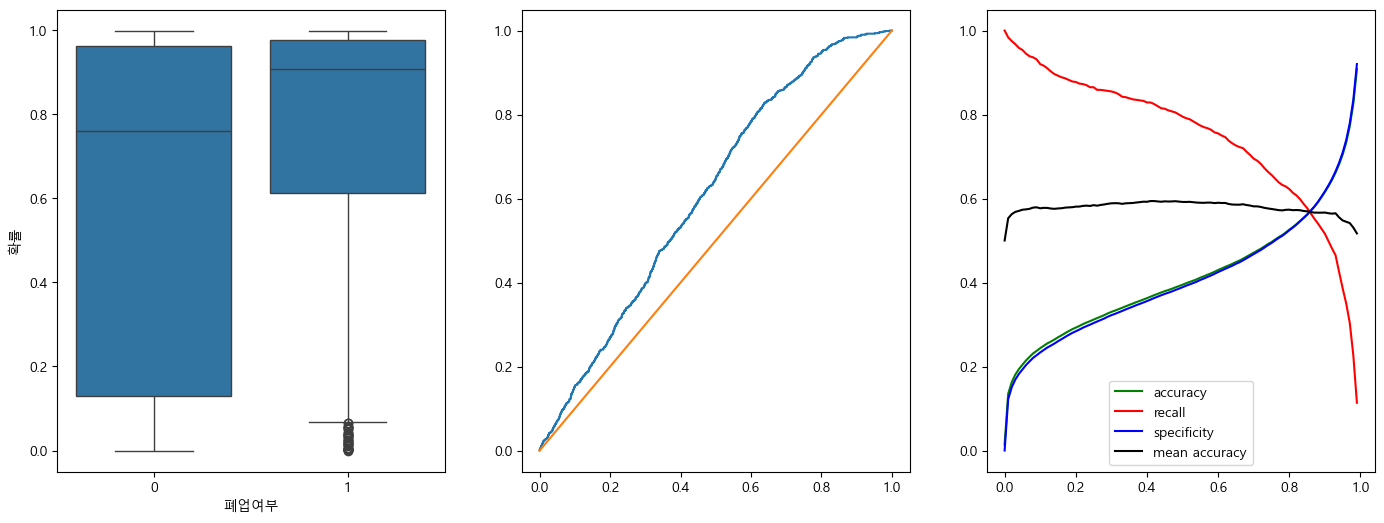

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(17, 6))

# Plotting Probabilities
temp = pd.concat([pd.Series(y_test).rename('폐업여부'), pd.Series(y_pred_prob).rename('확률')], axis=1)
sns.boxplot(x='폐업여부', y='확률', data=temp, ax=ax[0])

# AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
ax[1].plot(fpr, tpr, label='ROC'),
ax[1].plot([0, 1], [0, 1])

# Threshold
thresholds = np.arange(0, 1, 0.01)
a_lst, r_lst, s_lst = [], [], []
for t in thresholds:
    y_pred_temp = (y_pred_prob >= t).astype('int')
    a_lst.append(accuracy_score(y_test, y_pred_temp))
    r_lst.append(recall_score(y_test, y_pred_temp))
    s_lst.append(specificity_score(y_test, y_pred_temp))
mean_lst = [np.mean([r_lst[t], s_lst[t]]) for t in range(len(thresholds))]
plt.plot(thresholds, a_lst, c='g', label='accuracy')
plt.plot(thresholds, r_lst, c='r', label='recall')
plt.plot(thresholds, s_lst, c='b', label='specificity')
plt.plot(thresholds, mean_lst, c='k', label='mean accuracy')
plt.legend()
plt.show()

In [65]:
threshold = 0.82
y_pred = y_pred = (y_pred_prob >= threshold).astype(int)

In [66]:
# Metrics
cm = confusion_matrix(y_test, y_pred)
print("0-1 proportion at test set :", y_test.value_counts().values)
print("accuracy score :", accuracy_score(y_test, y_pred))
# print("precision score :", precision_score(y_test, y_pred))
print("specificity :", specificity_score(y_test, y_pred))
print("recall score :", recall_score(y_test, y_pred))
print("average accuracy :", np.mean([specificity_score(y_test, y_pred), recall_score(y_test, y_pred)]))
# print("f1_score :", f1_score(y_test, y_pred))
print("AUC score :", roc_auc_score(y_test, y_pred))

0-1 proportion at test set : [53308   800]
accuracy score : 0.5388851925778073
specificity : 0.537855481353643
recall score : 0.6075
average accuracy : 0.5726777406768215
AUC score : 0.5726777406768214


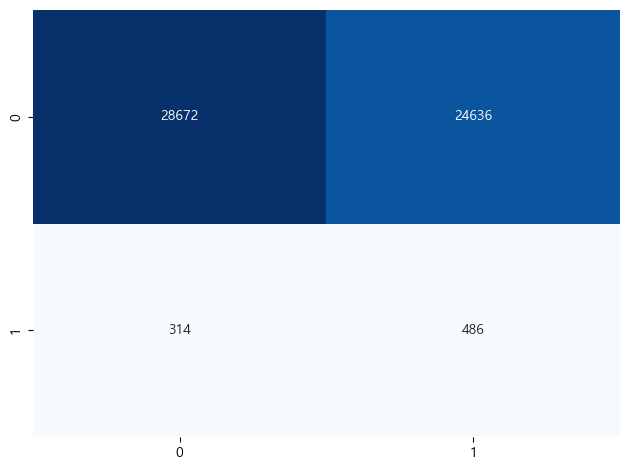

In [67]:
# Confusion Matrix
sns.heatmap(cm, cbar = False, annot=True, cmap = 'Blues', fmt='g')
plt.tight_layout()
plt.show()

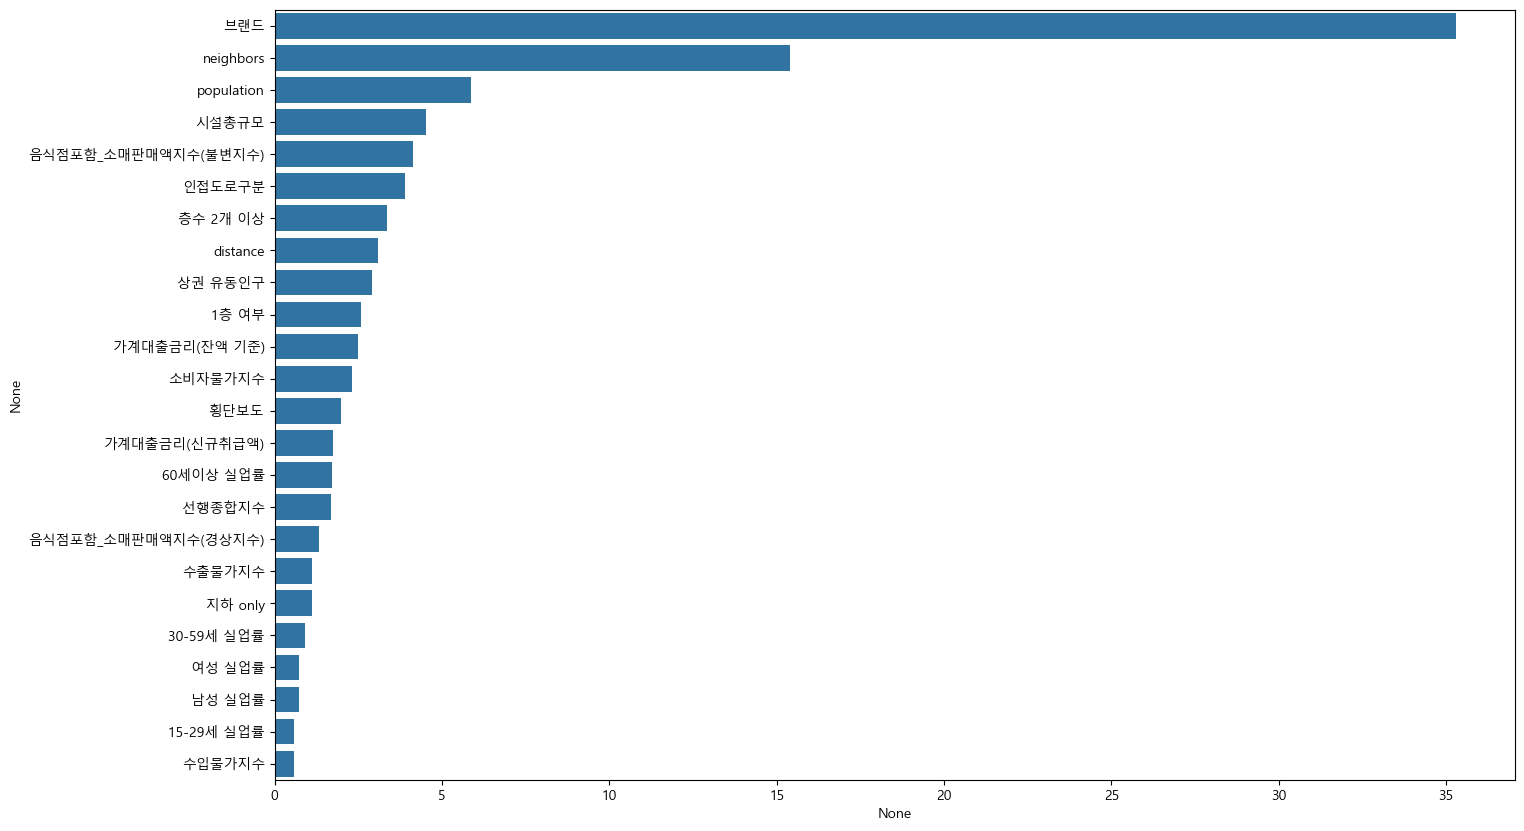

In [68]:
## Feature Importance
ser = pd.Series(cat_model.feature_importances_, index=X_res.columns)
ser = ser.sort_values(ascending=False)

plt.figure(figsize=(16, 10))
sns.barplot(x = ser, y=ser.index)
plt.show()